# Multi modal classification with a MLP

L'obiettivo del progetto è addestrare un sistema di classificazione multimodale che, sfruttando simultaneamente l'immagine e la relativa descrizione testuale, riconosca la categoria di scena o oggetto.

Nel caso specifico si è scelto di utilizzare il seguente dataset:

-https://huggingface.co/datasets/Bingsu/Human_Action_Recognition

Contenente una serie di immagini che mostrano svariate attività umane, accompagnate anche da una label testuale. Ci sono 15 possibili output che il modello dovrebbe correttamente predire.

In [ ]:
!pip install torch
!pip install torchvision
!pip install transformers
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Esplorazione dataset

In [ ]:
import os
import subprocess

#dato che sto riscontrando problemi a importare il dataset con la libreria datasets di HG
#clono la repo del dataset direttamente con git
if not os.path.exists("Human_Action_Recognition"):
    subprocess.run(["git", "clone", "https://huggingface.co/datasets/Bingsu/Human_Action_Recognition"], check=True)

#carico e controllo i file contenuti nella directory (locale, su colab) clonata
os.listdir("Human_Action_Recognition")

['.gitattributes', '.git', 'README.md', 'dataset_infos.json', 'data']

In [ ]:
from datasets import load_dataset, DatasetDict, Dataset
from collections import Counter
import pandas as pd
import json

#carico i file parquet dalla directory (quelli che contengono il dataset vero e proprio)
parquet_files = []
if os.path.exists("Human_Action_Recognition"):
    for root, dirs, files in os.walk("Human_Action_Recognition"):
        for file in files:
            if file.endswith('.parquet'):
                parquet_files.append(os.path.join(root, file))

#carico i file parquet
if parquet_files:
    all_dfs = []
    for parquet_file in parquet_files:
        df = pd.read_parquet(parquet_file)
        all_dfs.append(df)

    #combino tutti i file in un unico dataframe con pandas
    combined_df = pd.concat(all_dfs, ignore_index=True)

    #creo un dataset HF dal dataframe pandas appena creato (più comodo per le successive operazioni)
    dataset = DatasetDict({"train": Dataset.from_pandas(combined_df)})

In [ ]:
from collections import Counter
from datasets import DatasetDict

#una volta esserci assicurati che il dataset sia stato effettivamente caricato, proseguiamo con lo split
if dataset is not None:
    print(f"\nDataset caricato correttamente!")
    print(f"Dataset keys: {dataset.keys()}")

    #Prima divisione: 60% train, 40% rimanente
    temp_split = dataset["train"].train_test_split(test_size=0.4, seed=42)

    #Seconda divisione: dividiamo il 40% rimanente in 20% validation e 20% test
    test_valid = temp_split["test"].train_test_split(test_size=0.5, seed=42)

    full_dataset = DatasetDict({
        "train": temp_split["train"],        # 60%
        "validation": test_valid["train"],   # 20%
        "test": test_valid["test"]           # 20%
    })

    #eseguo le stampe per assicurarmi che tutto sia andato a buon fine
    print(f"\nDivisione finale del dataset:")
    print(f"Train: {len(full_dataset['train'])}")
    print(f"Test: {len(full_dataset['test'])}")
    print(f"Validation: {len(full_dataset['validation'])}")

else:
    print("Errore nel caricamento del dataset.")



Dataset caricato correttamente!
Dataset keys: dict_keys(['train'])

Divisione finale del dataset:
Train: 10800
Test: 3600
Validation: 3600


Tramite un print delle labels contenute nel dataset, dopo averlo unificato, noto un forte sbilanciamento: ci sono più di 3000 esempi per la label 0. Lo stesso sbilanciamento è presente negli split di test e validation.

Correggo questo sbilanciamento nelle fasi successive.

In [ ]:
labels = full_dataset["train"]["labels"]
label_counts = Counter(labels)

print("\nDistribuzione delle label nel dataset (di train):")
for label_id, count in sorted(label_counts.items()):
    print(f"Label {label_id}: {count}")


Distribuzione delle label nel dataset (di train):
Label 0: 3712
Label 1: 510
Label 2: 516
Label 3: 517
Label 4: 508
Label 5: 502
Label 6: 491
Label 7: 503
Label 8: 492
Label 9: 510
Label 10: 519
Label 11: 519
Label 12: 498
Label 13: 488
Label 14: 515


In [ ]:
from datasets import concatenate_datasets

#separiamo la label 0 dalle altre (bilanciamento train set)
label_0 = full_dataset["train"].filter(lambda x: x["labels"] == 0)
other_labels = full_dataset["train"].filter(lambda x: x["labels"] != 0)

#scelgo di prendere solo 500 esempi (più o meno una distribuzione media per label)
label_0_sampled = label_0.shuffle(seed=42).select(range(500))

#concatenazione dataset riequilibrato
balanced_train = concatenate_datasets([label_0_sampled, other_labels]).shuffle(seed=42)

#bilanciamento del test set
label_0_test = full_dataset["test"].filter(lambda x: x["labels"] == 0)
other_labels_test = full_dataset["test"].filter(lambda x: x["labels"] != 0)

#calcolo quanti esempi hanno le altre label per bilanciare
target_samples_test = len(other_labels_test) // 15  # 15 altre label
print(f"Target samples per test set: {target_samples_test}")

#campiono la label 0 per il test set
label_0_sampled_test = label_0_test.shuffle(seed=42).select(range(min(target_samples_test, len(label_0_test))))

#concatenazione test set riequilibrato
balanced_test = concatenate_datasets([label_0_sampled_test, other_labels_test]).shuffle(seed=42)

#bilanciamento del validation set
label_0_val = full_dataset["validation"].filter(lambda x: x["labels"] == 0)
other_labels_val = full_dataset["validation"].filter(lambda x: x["labels"] != 0)

#calcolo quanti esempi altre label per bilanciare
target_samples_val = len(other_labels_val) // 15  # 15 altre label
print(f"Target samples per validation set: {target_samples_val}")

#campiono la label 0 per il validation set
label_0_sampled_val = label_0_val.shuffle(seed=42).select(range(min(target_samples_val, len(label_0_val))))

#concatenazione validation set riequilibrato
balanced_val = concatenate_datasets([label_0_sampled_val, other_labels_val]).shuffle(seed=42)

#aggiorno il dataset completo con tutti i set bilanciati
full_dataset = DatasetDict({
    "train": balanced_train,
    "test": balanced_test,
    "validation": balanced_val
})

#verifico il nuovo bilanciamento di tutti i set
print("Bilanciamento finale:")
print(f"Train: {Counter(full_dataset['train']['labels'])}")
print(f"Test: {Counter(full_dataset['test']['labels'])}")
print(f"Validation: {Counter(full_dataset['validation']['labels'])}")

#verifica dimensioni finali
print(f"\nDimensioni finali:")
print(f"Train: {len(full_dataset['train'])}")
print(f"Test: {len(full_dataset['test'])}")
print(f"Validation: {len(full_dataset['validation'])}")


Filter:   0%|          | 0/10800 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10800 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Filter:   0%|          | 0/3600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3600 [00:00<?, ? examples/s]

Target samples per test set: 156


Filter:   0%|          | 0/3600 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3600 [00:00<?, ? examples/s]

Target samples per validation set: 155
Bilanciamento finale:
Train: Counter({10: 519, 11: 519, 3: 517, 2: 516, 14: 515, 9: 510, 1: 510, 4: 508, 7: 503, 5: 502, 0: 500, 12: 498, 8: 492, 6: 491, 13: 488})
Test: Counter({8: 193, 12: 183, 6: 179, 7: 176, 4: 172, 9: 164, 3: 163, 11: 162, 10: 161, 14: 160, 1: 160, 13: 159, 2: 159, 0: 156, 5: 154})
Validation: Counter({13: 193, 5: 184, 1: 170, 6: 170, 9: 166, 14: 165, 2: 165, 7: 161, 3: 160, 4: 160, 10: 160, 12: 159, 11: 159, 0: 155, 8: 155})

Dimensioni finali:
Train: 7588
Test: 2501
Validation: 2482


Effettuo una stampa, utilizzando un bar chart, della distrubuzione delle labels all'interno del train set per assicurarci di aver correto lo sbilanciamento iniziale della label 0

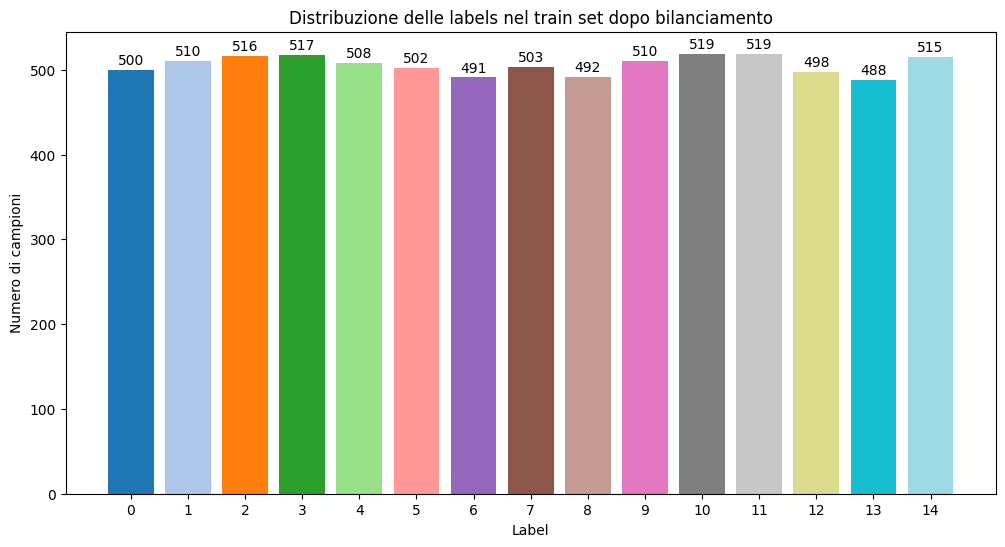

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

#estraggo le labels e ne conto le occorrenze con la funzione counter di collections
labels = full_dataset["train"]["labels"]
label_counts = Counter(labels)

#ordina le label
labels_sorted = sorted(label_counts.keys())
counts_sorted = [label_counts[label] for label in labels_sorted]

#plotto la figura e aggiungo la colormap (integrata già in matplotlib)
plt.figure(figsize=(12, 6))
bar_colors = plt.cm.tab20(np.linspace(0, 1, len(labels_sorted)))
bars = plt.bar(labels_sorted, counts_sorted, color=bar_colors)

#aggiungo il count della specifica label sopra la rispettiva barra per maggiore chiarezza
for bar, count in zip(bars, counts_sorted):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 3, str(count), ha='center', va='bottom', fontsize=10)

plt.title("Distribuzione delle labels nel train set dopo bilanciamento")
plt.xlabel("Label")
plt.ylabel("Numero di campioni")
plt.xticks(labels_sorted)

plt.show()


# Preprocressing multimodale: creazione dataset PyTorch

Dopo aver effettuato la divisione in train, test e validation, passiamo adesso al vero preprocessing multimodale.
L'obiettivo è ottenere un dataset pytorch pronto per il training

In [ ]:
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import io

with open('Human_Action_Recognition/dataset_infos.json', 'r') as f:
    dataset_info = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#stampo il nome di ogni label per maggiore chiarezza cosi dopo aggiungo con più facilità una descrizione in linguaggio naturale
label_names = dataset_info[next(iter(dataset_info))]['features']['labels']['names']
print(f"Label names: {label_names}")

Label names: ['calling', 'clapping', 'cycling', 'dancing', 'drinking', 'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music', 'running', 'sitting', 'sleeping', 'texting', 'using_laptop']


In [ ]:
#istanzio il dizionario con descrizioni specifiche per ogni label, ci serviranno
#per estrarre gli embeddings testuali e aiutare CLIP alla classificazione dell'immagine
#Si è deciso di NON inserire riferimenti alla label specifica, ma solo descrizioni dell'azione in questione
label_descriptions = {
    0: "a photo of a person speaking on a handheld device",
    1: "a photo of a person applauding with their hands together",
    2: "a photo of a person riding a two-wheeled vehicle outdoors",
    3: "a photo of a person moving rhythmically to music",
    4: "a photo of a person holding a cup near their mouth",
    5: "a photo of a person consuming food at a table",
    6: "a photo of two people engaged in physical combat",
    7: "a photo of two people embracing each other",
    8: "a photo of a person smiling with an open mouth",
    9: "a photo of a person wearing headphones",
    10: "a photo of a person moving quickly on foot outdoors",
    11: "a photo of a person resting on a chair or bench",
    12: "a photo of a person lying down with eyes closed",
    13: "a photo of a person looking at a handheld screen",
    14: "a photo of a person typing on a portable computer"
}


In [ ]:
#funzione che aggiunge una descrizione testuale a ogni esempio del dataset
#per "example" si intende ogni singolo esempio del dataset
def add_descriptive_text(example):
    label_id = example["labels"]
    example["text"] = label_descriptions[label_id]
    return example

##applichiamo la funzione di arricchimento testuale a ogni esempio del dataset (train, test, ecc.)
full_dataset = full_dataset.map(add_descriptive_text)

#stampiamo il primo esempio del train set per verificare che il campo "text" sia stato aggiunto
print(f"Esempio con text aggiunto:\n{full_dataset['train']['text'][0]}")

#verifica di alcune descrizioni per label diverse
print("\nEsempi di descrizioni per diverse label:")
for i in range(min(5, len(full_dataset['train']))):
    example = full_dataset['train'][i]
    print(f"Label {example['labels']}: {example['text']}")

Map:   0%|          | 0/7588 [00:00<?, ? examples/s]

Map:   0%|          | 0/2501 [00:00<?, ? examples/s]

Map:   0%|          | 0/2482 [00:00<?, ? examples/s]

Esempio con text aggiunto:
a photo of two people engaged in physical combat

Esempi di descrizioni per diverse label:
Label 6: a photo of two people engaged in physical combat
Label 14: a photo of a person typing on a portable computer
Label 10: a photo of a person moving quickly on foot outdoors
Label 0: a photo of a person speaking on a handheld device
Label 5: a photo of a person consuming food at a table


In [ ]:
#inizializziamo clip processor per feature extraction da immagini e tokenizer testo
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
#definiamo una classe custom di tipo Dataset (torch.utils.data.Dataset)
#per gestire i dati multimodali (immagini + testo)
class MultimodalDataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

#ritorniamo il numero totale di esempi nel dataset (serve a pytorch per capire la dimensione)
    def __len__(self):
        return len(self.dataset)

#funzione che ritorna un singolo esempio a partire dall’indice (serve durante il batch sampling)
    def __getitem__(self, idx):
        example = self.dataset[idx]

        #preprocessing immagine - convertiamo da bytes a PIL Image
        #usiamo Image.open perché il modello CLIP accetta immagini in formato PIL (non raw bytes né tensor diretti)
        image_bytes = example["image"]["bytes"]
        #la conversione in "RGB" serve per assicurarci che tutte le immagini abbiano 3 canali
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        #usiamo clip_processor per trasformare l'immagine PIL in un tensore già normalizzato e rescalato come richiesto dal modello CLIP
        processed = clip_processor(images=image, return_tensors="pt", padding=True)
        #squeeze(0) rimuove la dimensione del batch (CLIP restituisce un batch anche per un'immagine singola)
        image_features = processed["pixel_values"].squeeze(0) #shape (3, 224, 224) --> 3 canali (RGB) 244x244 pixel
        #senza squeeze la dimensione sarebbe stata (1, 3, 244, 244)


        #preprocessiamo il testo associato all'immagine (già inserito prima con .map())
        #qui usiamo il tokenizer di clip per ottenere gli input_ids e l'attention_mask; Anche qui usiamo squeeze per lo stesso motivo di prima
        text = example["text"]
        text_inputs = clip_processor.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=77)
        input_ids = text_inputs["input_ids"].squeeze(0)
        attention_mask = text_inputs["attention_mask"].squeeze(0)

        label = torch.tensor(example["labels"])

        return {
            "image": image_features,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "label": label
        }

In [ ]:
#creiamo i dataset pytorch per train, validation, test
train_dataset = MultimodalDataset(full_dataset["train"])
val_dataset = MultimodalDataset(full_dataset["validation"])
test_dataset = MultimodalDataset(full_dataset["test"])

In [ ]:
#creiamo dataloader per batching efficiente tramite la classe DataLoader di Pytorch
#suddivide automaticamente il dataset in mini-batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
#test di lettura di un batch per confermare corretto caricamento
for batch in train_loader:
    print("batch keys:", batch.keys())
    print("image shape:", batch["image"].shape)
    print("input_ids shape:", batch["input_ids"].shape)
    print("attention_mask shape:", batch["attention_mask"].shape)
    print("label shape:", batch["label"].shape)
    break

batch keys: dict_keys(['image', 'input_ids', 'attention_mask', 'label'])
image shape: torch.Size([32, 3, 224, 224])
input_ids shape: torch.Size([32, 77])
attention_mask shape: torch.Size([32, 77])
label shape: torch.Size([32])


Questo print è un test molto utile per verificare che il DataLoader stia funzionando correttamente e che tutti i tensori abbiano forme compatibili tra loro.

Analizzando l'output vediamo come:

-32 in tutte le shape è il batch size: vale a dire che stiamo lavorando su 32 esempi contemporaneamente.

-image ha 32 immagini, ciascuna con 3 canali RGB e dimensione 244x244

-input_ids e attention_mask: sono 32 sequenze testuali tokenizzate, ciascuna lunga 77 token (è il massimo supportato da CLIP per il testo)

-Label 32 ovvero 32 etichette, una per ogni esempio nel batch.

# Fase di training

epoca 1/10 - loss: 2.5121 - accuracy train: 0.3591 - accuracy val: 0.9936
epoca 2/10 - loss: 1.1834 - accuracy train: 0.8434 - accuracy val: 1.0000
epoca 3/10 - loss: 0.2643 - accuracy train: 0.9775 - accuracy val: 1.0000
epoca 4/10 - loss: 0.1104 - accuracy train: 0.9897 - accuracy val: 1.0000
epoca 5/10 - loss: 0.0738 - accuracy train: 0.9917 - accuracy val: 1.0000
epoca 6/10 - loss: 0.0463 - accuracy train: 0.9974 - accuracy val: 1.0000
epoca 7/10 - loss: 0.0429 - accuracy train: 0.9966 - accuracy val: 1.0000
epoca 8/10 - loss: 0.0353 - accuracy train: 0.9972 - accuracy val: 1.0000
epoca 9/10 - loss: 0.0315 - accuracy train: 0.9968 - accuracy val: 1.0000
epoca 10/10 - loss: 0.0291 - accuracy train: 0.9976 - accuracy val: 1.0000


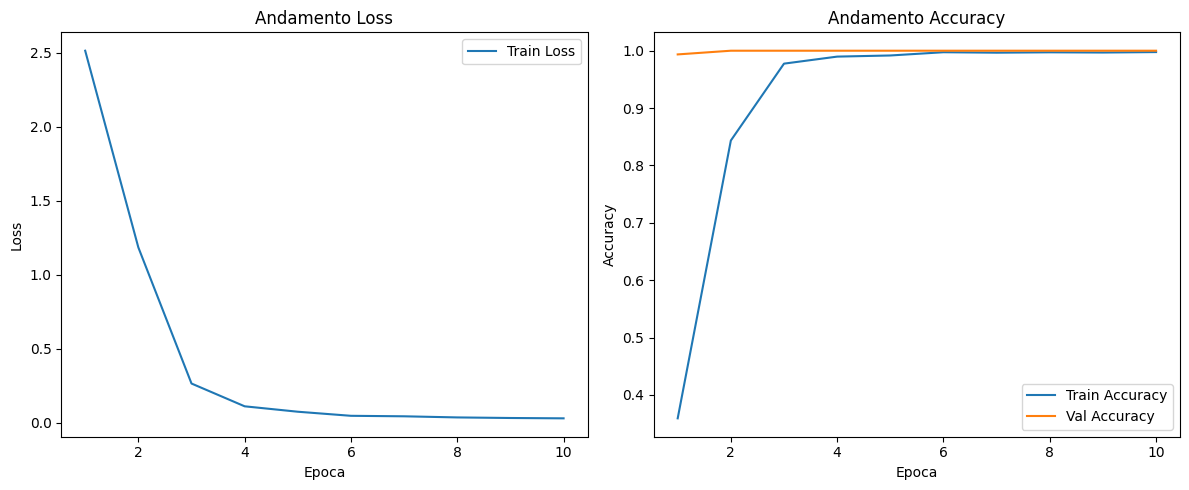

In [ ]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from transformers import CLIPModel
from torch.utils.data import Dataset, DataLoader


#in questo blocco prepariamo clip per estrarre feature da immagini e testi,
#e costruiamo un mlp che userà queste feature fuse per fare classificazione

#istanziamo il modello, lo mettiamo in modalità training, e lo portiamo sulla gpu (di colab)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_model.train()
clip_model = clip_model.to(device)

#definiamo l'mlp multimodale: una rete neurale fully-connected che prende in input
#la concatenazione delle feature visive e testuali (maggiori info sulla relazione)
class MultimodalMLP(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=256, output_dim=15, dropout=0.5):
        super(MultimodalMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)
        #dropout e ReLU sono usate per la regolarizzazione e per rendere non lineare il modello

    #definizione del passaggio in avanti: applica fc1, dropout, relu, poi fc2, dropout, relu, infine fc3 per ottenere i logit
    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

#istanziamo il nostro modello mlp e lo mandiamo su gpu o cpu
model = MultimodalMLP()
model = model.to(device)

#funzione di loss per classificazione multi-classe
criterion = nn.CrossEntropyLoss()

#definiamo l’ottimizzatore sgd con due gruppi di parametri:
#l’mlp viene aggiornato con un learning rate più alto (0.01)
#clip viene aggiornato con lr più basso (0.001), perché è già pre-addestrato e vogliamo modificarlo lentamente
#si fa per aggiornare più velocemente solo l'mlp, lasciando clip quasi invariato, evitando di rovinare le sue conoscenze pre-addestrate.
optimizer = optim.SGD([
    {'params': model.parameters(), 'lr': 0.01},
    {'params': clip_model.parameters(), 'lr': 0.001}
])

#aggiungiamo uno scheduler per learning rate: lo usiamo per ridurre il learning rate durante il training, abbassandolo
#ogni 5 epoche (in questo caso) e moltiplicandolo per gamma.
#cosi il modello fa aggiornamento più piccoli man mano che si avvicina al minimo, evitando overshooting
#(è più utile quando si hanno tante epoche, ma ho deciso comunque di inserirlo)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#numero epoche
num_epochs = 10

train_losses = []
train_accuracies = []
val_accuracies = []

#inizio del training loop, mettiam sia l'MLP che CLIP in modalità training
#ed inizializziamo le variabili per tenere traccia della loss totale e del numero totale di esempi.
#serviranno per calcolare l'accuratezza e la loss media a fine epoca
for epoch in range(num_epochs):
    model.train()
    clip_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    #per ogni batch nel dataloader, eseguiamo un passo/ciclo di addestramento
    #per prima cosa estraiamo i tensori immagine, testo e label dal batch e li spostiamo su gpu
    for batch in train_loader:
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        #usiamo le due funzioni di clip per ottenere i vettori di embedding dall'immagine e dal testo
        image_features = clip_model.get_image_features(pixel_values=images)
        text_features = clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

        #concateniamo le feature visive e testuali, la shape risultante sarà (batch, 1024) ovvero 512 (immagine) + 512 (Testo)
        combined_features = torch.cat((image_features, text_features), dim=1)
        #passiamo il vettore concatenato al nostro mlp che restituisce i logit per ogni classe
        outputs = model(combined_features)
        #calcoliamo la cross-entropy tra i logit del modello e le label vere
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        #aggiorniamo i parametri del modello e di clip con i gradienti appena calcolati
        optimizer.step()

        #accumuliamo la loss pesata per il numero di esempi
        #calcoliamo le predizioni e aggiorniamo il conteggio dei corretti per calcolare accuracy a fine epoca
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    #riduciamo il learning rate secondo la logica dello scheduler
    scheduler.step()

    #calcoliamo la loss media e l’accuratezza globale su tutti i dati visti durante l’epoca
    #sono metriche importanti per monitorare l'apprendimento
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    #salviamo loss e accuracy in liste per poi poterle plottare
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    #valutazione sul validation set (passiamo entrambi i modelli in "eval", disattiva dropout etc.)
    model.eval()
    clip_model.eval()
    ##resettiamo le metriche per la valutazione sul validation set
    val_correct = 0
    val_samples = 0

    #questo blocco esegue la valutazione del modello sul validation set
    #usiamo la funzione di torch "no_grad" che disattiva i gradienti per rendere la valutazione più veloce
    #dato che non serve fare backpropagation
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            image_features = clip_model.get_image_features(pixel_values=images)
            text_features = clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

            combined_features = torch.cat((image_features, text_features), dim=1)
            outputs = model(combined_features)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_samples += labels.size(0)

    #calcoliamo e salviamo l'accuracy finale sul validation set per questa epoca
    val_accuracy = val_correct / val_samples
    val_accuracies.append(val_accuracy)

    print(f"epoca {epoch+1}/{num_epochs} - loss: {avg_loss:.4f} - accuracy train: {accuracy:.4f} - accuracy val: {val_accuracy:.4f}")

#plottiamo i grafici finali
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Andamento Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.title('Andamento Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


I valori sembrano promettenti. Verifichiamo se l'accuracy rimane alta anche su dati non visti, quindi sul test set.

Nella valutazione sul test, otteniamo:
Un singolo valore di loss e un singolo valore di accuracy che riassumono il comportamento del modello su tutti i dati di test.


In [ ]:
test_dataset = MultimodalDataset(full_dataset["test"])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#inizializziamo metriche
test_loss = 0
test_correct = 0
test_samples = 0

from tqdm import tqdm

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluation Test"):
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        image_features = clip_model.get_image_features(pixel_values=images)
        text_features = clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)

        combined_features = torch.cat((image_features, text_features), dim=1)
        outputs = model(combined_features)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)

        preds = outputs.argmax(dim=1) #questa variabile rappresenza la predizione del modello
        test_correct += (preds == labels).sum().item() #Questa riga confronta le predizioni fatte dal modello (preds) con le etichette reali presenti nel dataset (labels) e conta quanti sono corretti.
        test_samples += labels.size(0)

#calcolo finali
avg_test_loss = test_loss / test_samples
test_accuracy = test_correct / test_samples

print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluation Test: 100%|██████████| 79/79 [00:22<00:00,  3.46it/s]


Test Loss: 0.0007
Test Accuracy: 1.0000


Selezioniamo un campione casuale dal dataset per visualizzare la foto in questione, l'etichetta reale e l'etichetta predetta dal modello.

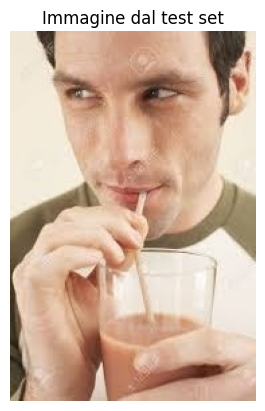

Etichetta reale: 4 (drinking)
Etichetta predetta: 4 (drinking)


In [ ]:
from io import BytesIO

#scegliamo un indice random
idx = 1

#estraiamo l'esempio dal test set
example = full_dataset["test"][idx]

#ricostruiamo l'immagine PIL dai bytes
img_pil = Image.open(BytesIO(example["image"]["bytes"])).convert("RGB")

#visualizziamo l'immagine
plt.imshow(img_pil)
plt.axis('off')
plt.title("Immagine dal test set")
plt.show()

#prepariamo l'immagine per CLIP
inputs = clip_processor(images=img_pil, return_tensors="pt").to(device)

#recuperiamo le label testuali
label_id = example["labels"]
label_list = dataset_info[next(iter(dataset_info))]['features']['labels']['names']
label_text = label_list[label_id]

#estraiamo le embedding dell'immagine
with torch.no_grad():
    image_features = clip_model.get_image_features(pixel_values=inputs["pixel_values"])
    text = f"a photo of a person {label_text.replace('_', ' ')}"
    text_inputs = clip_processor.tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=77).to(device)
    text_features = clip_model.get_text_features(input_ids=text_inputs["input_ids"], attention_mask=text_inputs["attention_mask"])

#concatenazione delle feature multimodali
combined_features = torch.cat((image_features, text_features), dim=1)

#predizione
model.eval()
with torch.no_grad():
    outputs = model(combined_features)
    pred_label_id = outputs.argmax(dim=1).item()
    pred_label_text = label_list[pred_label_id]

print(f"Etichetta reale: {label_id} ({label_text})")
print(f"Etichetta predetta: {pred_label_id} ({pred_label_text})")


# Valutazione


Valutazione completa: 100%|██████████| 79/79 [00:23<00:00,  3.43it/s]


REPORT DI VALUTAZIONE FINALE

Accuracy:  1.0000 (100.00%)
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000


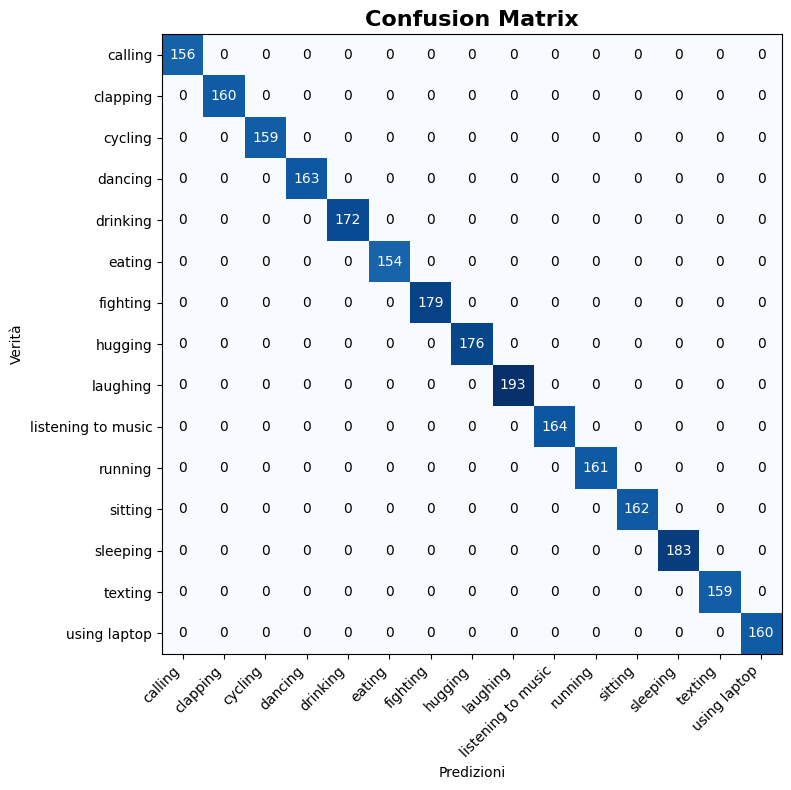

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

test_dataset = MultimodalDataset(full_dataset["test"])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []
all_probs = []

model.eval()
clip_model.eval()

from tqdm import tqdm

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Valutazione completa"):
        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        image_features = clip_model.get_image_features(pixel_values=images)
        text_features = clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        combined_features = torch.cat((image_features, text_features), dim=1)
        outputs = model(combined_features)

        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#conversione in array
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

#calcolo delle metriche
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
#Accuracy: proporzione di esempi correttamente classificati sul totale
#Precision: percentulae di predizioni positibe corrette
#Recall: percentuale di elementi positivi riconosciuti correttamente
#F1-Score: media armonica tra precision e recall. Serve ad avere una metrica unica.

#ottiengo i nomi delle label
label_list = dataset_info[next(iter(dataset_info))]['features']['labels']['names']

#METRICHE GENERALI
print("="*80)
print("REPORT DI VALUTAZIONE FINALE")
print("="*80)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold')
ax.set_xlabel('Predizioni')
ax.set_ylabel('Verità')

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}',
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax.set_xticks(range(len(label_list)))
ax.set_xticklabels([label.replace('_', ' ') for label in label_list],
                   rotation=45, ha='right', fontsize=10)
ax.set_yticks(range(len(label_list)))
ax.set_yticklabels([label.replace('_', ' ') for label in label_list],
                   fontsize=10)

plt.tight_layout()
plt.show()